In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from imblearn.over_sampling import RandomOverSampler
# Load data in a dataframe:
df = pd.read_csv("winequality-red.csv")
y = df['quality']
df.drop('quality', axis='columns', inplace=True)


#df.drop('pH', axis='columns', inplace=True)

# Linear Regression


In [74]:
dfl=pd.read_csv("winequality-red.csv")
data = dfl.to_numpy()
vif = [variance_inflation_factor(data, i) for i in range(data.shape[1])]
for i in range(11):
    print("VIF of " + dfl.columns[i] + ": " + str(vif[i]))
dfl.drop('quality',axis='columns', inplace=True) #for convinience
dfl['constant'] = [1]*1599 #for linear reg
res = sm.OLS(y,dfl).fit()
print(res.summary())


VIF of fixed acidity: 74.45531208173739
VIF of volatile acidity: 17.960867041827157
VIF of citric acid: 9.192549018095306
VIF of residual sugar: 4.664003138644531
VIF of chlorides: 6.641291238331208
VIF of free sulfur dioxide: 6.460602792740036
VIF of total sulfur dioxide: 6.605273810188336
VIF of density: 1528.1543016133344
VIF of pH: 1078.1710892657966
VIF of sulphates: 22.462103065111226
VIF of alcohol: 147.61634505774757
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Fri, 26 Nov 2021   Prob (F-statistic):          1.79e-145
Time:                        21:36:57   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:     

We can observe from VIF and P-values for coefficients fo the regression that some variables ( density, citric acid, fixed acidity, residual sugar, free sulfur dioxide) are redundant. From p-values we can not reject H_0 , thus their coefficient is 0 and we can remove them from the regression analysis.

In [14]:
#Remove variables according to P-values
dfl.drop('free sulfur dioxide', axis='columns', inplace=True)
dfl.drop('density', axis='columns', inplace=True)
dfl.drop('fixed acidity', axis='columns', inplace=True)
dfl.drop('citric acid', axis='columns', inplace=True)
dfl.drop('residual sugar', axis='columns', inplace=True)

data = dfl.to_numpy()
vif = [variance_inflation_factor(data, i) for i in range(data.shape[1])]
for i in range(5):
    print("VIF of " + dfl.columns[i] + ": " + str(vif[i]))

VIF of volatile acidity: 1.2279668016466074
VIF of chlorides: 1.3329767249777102
VIF of total sulfur dioxide: 1.053829759009383
VIF of pH: 1.2187072163627097
VIF of sulphates: 1.3212374333930235


As we see from the new VIF values above, we can keep all the remaining variables in the regression, since their VIF is low. Thus our choice to remove some variables was effecetive.

### Train-Test Split for linear

In [15]:
Xtrain,Xtest,ytrain,ytest = train_test_split(dfl,y,random_state =0)

In [16]:
from sklearn.metrics import r2_score

res = sm.OLS(ytrain,Xtrain).fit()
linpred=res.predict(Xtest)
print("Testing R^2:",r2_score(ytest, linpred))
print(res.summary())

Testing R^2: 0.3400315594249613
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     112.1
Date:                Fri, 26 Nov 2021   Prob (F-statistic):          3.33e-112
Time:                        20:59:06   Log-Likelihood:                -1188.5
No. Observations:                1199   AIC:                             2391.
Df Residuals:                    1192   BIC:                             2427.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------


In [17]:
print(round(linpred))

1109    6.0
1032    5.0
1002    7.0
487     5.0
979     6.0
       ... 
489     6.0
362     6.0
526     6.0
442     6.0
1229    5.0
Length: 400, dtype: float64




#### *Result Anlysis*

<p> From the above summray of the linear regression we can see that the p-value for each coefficinet is small, thus for each of them we can reject he null hypothesis and say that coefficients are signifficantly different from 0. </p>

<p> We were using 7 variables for the regression, the magnitude of the coefficients as well as the 95% confidence interval for them is given below. </p>

|Variable| Coefficient| 95% confidence interval |
|:-| :- | :-: |
|Volatile Acidity|  -1.1704 | \[-1.394 ,-0.947 \]|
|Chlorides|  -1.9238 | \[-2.803 ,-1.044 \]|
|Total Sulfur Dioxide|  -0.0023   | \[-0.003 ,-0.001 \]|
|pH| -0.4174 | \[-0.684 , -0.151 \]|
|Sulphates| 0.8148 | \[0.575 , 1.055 \]|
|Alcohol| 0.2832 | \[0.245 ,  0.321 \]|


<p> The accuracy of the model was decent but not impressive, the accuracy values are in the table below </p>

|Variable| Accuracy|
|:-|:- |
|Testing Accuracy| 0.34|
|Training Accuracy| 0.36|



# Classification

### Train-Test Split for Classification

In [24]:
yc = np.zeros(len(y))
for i in range(len(y)):
    yc[i] = y[i]>=7.0
Xtrain,Xtest,ytrain,ytest = train_test_split(df,yc,random_state =0)
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtrain)
X_test = scaler.transform(Xtest)

## Random Forest

In [19]:
tree_clf = RandomForestClassifier(n_estimators=100,random_state=0)
tree_clf.fit(Xtrain,ytrain)
ypred=tree_clf.predict(Xtest)
print(tree_clf.score(Xtest, ytest))
print(metrics.classification_report(ytest,ypred))

0.93
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       355
         1.0       0.72      0.62      0.67        45

    accuracy                           0.93       400
   macro avg       0.84      0.80      0.81       400
weighted avg       0.93      0.93      0.93       400



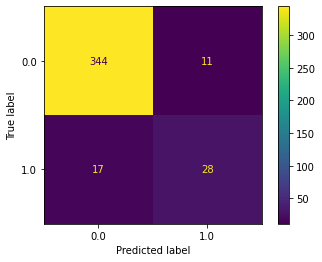

In [20]:
from sklearn import svm
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred)    

In [21]:
importances = tree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_clf.estimators_], axis=0)
for i in range(len(std)):
    print("Feature "+str((i+1))+" importance is:"+str(round(importances[i],2)) +" 95% confidence interval: ["+str(round(importances[i]-2*std[i],2))+","+str(round(importances[i]+2*std[i],2))+"]")

Feature 1 importance is:0.07 95% confidence interval: [0.01,0.14]
Feature 2 importance is:0.12 95% confidence interval: [0.02,0.22]
Feature 3 importance is:0.09 95% confidence interval: [0.01,0.16]
Feature 4 importance is:0.07 95% confidence interval: [0.02,0.12]
Feature 5 importance is:0.07 95% confidence interval: [0.01,0.13]
Feature 6 importance is:0.06 95% confidence interval: [0.01,0.1]
Feature 7 importance is:0.08 95% confidence interval: [0.03,0.14]
Feature 8 importance is:0.09 95% confidence interval: [0.01,0.17]
Feature 9 importance is:0.06 95% confidence interval: [0.0,0.11]
Feature 10 importance is:0.12 95% confidence interval: [0.03,0.22]
Feature 11 importance is:0.17 95% confidence interval: [0.06,0.27]


## SVM Classification

0.8875


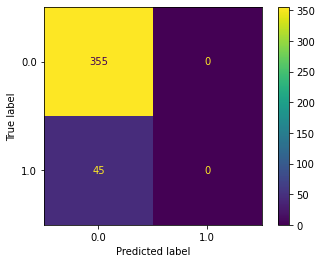

In [22]:
clf = svm.SVC(random_state=0)
clf.fit(Xtrain, ytrain)
predicted = clf.predict(Xtest)
print(clf.score(Xtest, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

## Nonbinary Classification

### Data Train-test Split and Standardisation
We begin by resplitting and standardising our data.

Text(0.5, 1.0, 'Histogram of the Training Set')

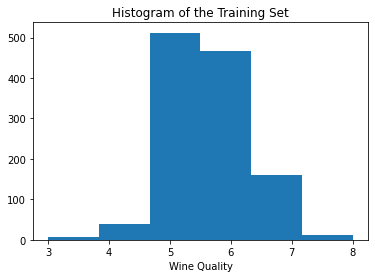

In [105]:
X_train,X_test,ytrain,ytest = train_test_split(df,y,random_state =0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plt.hist(ytrain, bins=6)
plt.xlabel('Wine Quality')
plt.title('Histogram of the Training Set')

The graph above shows that the data is very imbalanced, hence this needs to be taken into account by our models.

After trying to use the *class_weight = 'balanced'* parameter for our models, the accuracy of our models diminished. We realized that working with a completely balanced dataset does not reflect the reality of our data, so we decided to use oversapling since the dataset is small, so undersampling would not work quite well. 

When using completely balanced oversampling of all classes, the accuracy of our models decreased and more points of classes 5 and 6 were mislabeled as other classes, but there was siginificant improvemnt in the correct identification of data from class 7.

To fix that, we tried ovarsampling in a bit more catious manner, by doubling classes 3, 4, 7, and 8, which have significantly less data than classes 5 and 6. The results were the same for the Logistic Regressor and the SVM, but the Random Forest Classifier performed better with this oversampling.<br>

Text(0.5, 1.0, 'Histogram of the Oversampled Training Set')

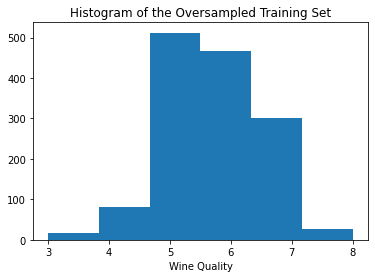

In [108]:
# Oversampling of the training data
ros = RandomOverSampler(sampling_strategy={3:16, 4:80, 7:300, 8:26})
X_train_ros, ytrain_ros = ros.fit_resample(X_train, ytrain)

plt.hist(ytrain_ros, bins=6)
plt.xlabel('Wine Quality')
plt.title('Histogram of the Oversampled Training Set')

### Logistic Regression Classifier

Accuracy is not affected by scaling, but the number of iterations blew up.

Accuracy when max_iter=1000, class_weight='balanced': 0.43

Normal accuracy with max_iter = 1000: 0.635. Different solvers did not change the accuracy for this one. 

0.635


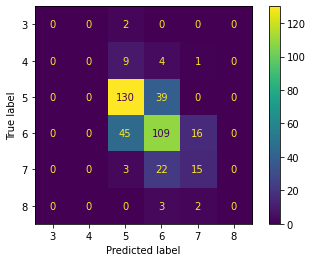

In [109]:
# Logistic Regression without oversampling

classifier = LogisticRegression(max_iter=1000, multi_class='multinomial')
classifier.fit(X_train, ytrain)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  


0.585


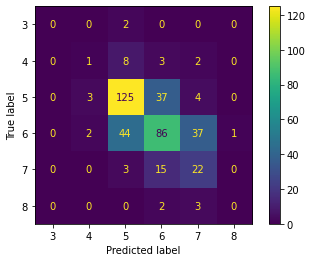

In [110]:
# Logistic regression with oversampling
classifier.fit(X_train_ros, ytrain_ros)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

### Random Forest Classifier

Default accuracy is 0.7

0.7


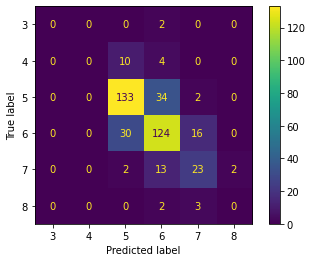

In [111]:
#Random forest classifier without oversampling
classifier = RandomForestClassifier(
    n_estimators = 1000,
    random_state = 0,
    oob_score = True
)
classifier.fit(X_train, ytrain)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

0.705


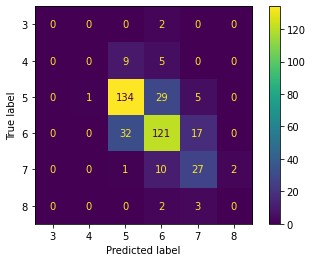

In [112]:
# Random forest classifier with oversampling
classifier.fit(X_train_ros, ytrain_ros)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

0.63


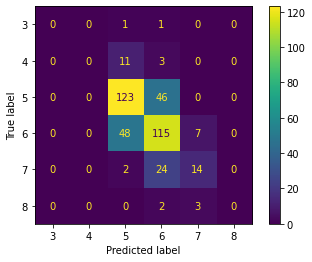

In [113]:
# SVM without oversampling
lf = svm.SVC(random_state=0)
clf.fit(X_train, ytrain)
predicted = clf.predict(X_test)
print(clf.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

0.6


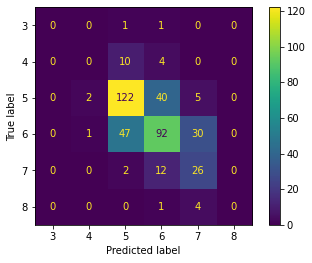

In [114]:
# SVM with oversampling
clf.fit(X_train_ros, ytrain_ros)
predicted = clf.predict(X_test)
print(clf.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  